In [44]:
#given a dataset for H(z), z, err(H), we do an MCMC analysis and find corner plots for the data

import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
import pandas as pd

In [45]:
def log_likelihood(theta, x, y, yerr):
    alpha_t, Omg_m, Omg_r, H0 = theta #f is the underestimation of the variance? No idea what it means
    model = H0 * np.sqrt(Omg_m*(1+x)**3 + Omg_r*(1+x)**4 + (1 - Omg_m - Omg_r + alpha_t)) * (1 - alpha_t/2 * (Omg_r*(1+x)**4 + Omg_m*(1+x)**3 + (1-Omg_m - Omg_r + alpha_t)))
    sigma2 = yerr**2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [46]:
def log_prior(theta):
    alpha_t, Omg_m, Omg_r, H0 = theta
    if -1 < alpha_t < 1 and 0 < Omg_m < 1 and 0 < Omg_r < 1 and 50 < H0 < 100:
        return 0.0
    return -np.inf

In [47]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [48]:
#import data
df = pd.read_excel (r'C:\Users\Carola\Desktop\Newcastle\PhD research\Assorted Computer Programs\Hubble data as a function of redshift z for cosmic chronometers.xlsx')


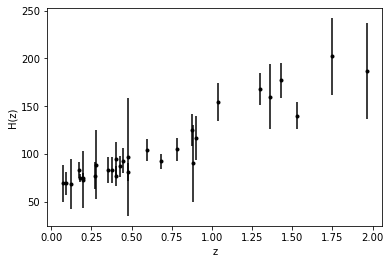

In [49]:
#get the data

# Choose the "true" parameters.
alpha_t_est = 0.0
Omg_m_est = 0.4
H0_est = 67
Omg_r_est = 9e-5

# Plot our data
x = np.array(df.z)
yerr = np.array(df.Err)
y = np.array(df.H_z)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.xlabel("z")
plt.ylabel("H(z)");

In [50]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
pos = [alpha_t_est, Omg_m_est ,Omg_r_est , H0_est] + 1e-5 * np.random.randn(50, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 10000, progress=True);

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:19<00:00, 125.69it/s]


(33000, 4)


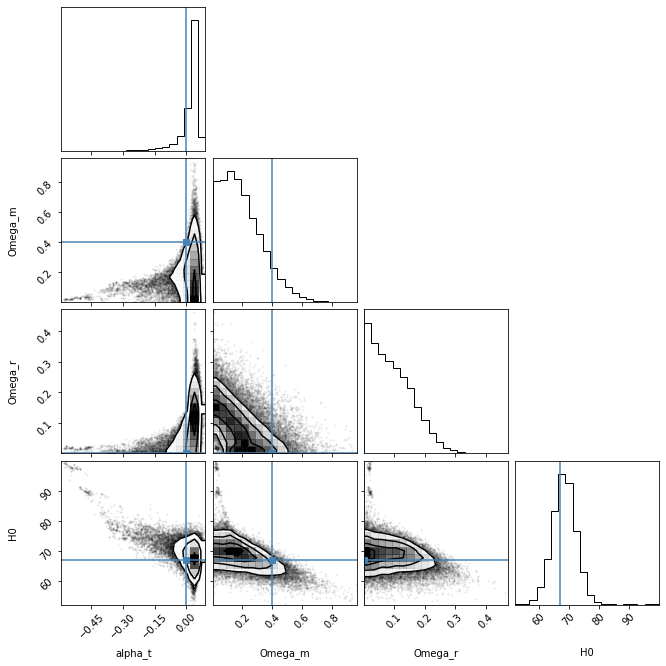

In [53]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["alpha_t", "Omega_m","Omega_r", "H0"]
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[alpha_t_est, Omg_m_est, Omg_r_est, H0_est]
);

In [52]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>